# **PASO 1: Comprobación de la precisión de los modelos**





In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Definir la ruta del archivo de Excel
file_path = 'training_data.xlsx'  

# Cargar los datos del archivo
data = pd.read_excel(file_path)

# Asegurarse de que las columnas estén correctamente asignadas
df = data[['id', 'sentence', 'difficulty']]

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba (80% entrenamiento, 20% prueba)
train_val_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Dentro del conjunto de entrenamiento, dividir en conjunto de entrenamiento y conjunto de validación (75% entrenamiento, 25% validación)
train_data, val_data = train_test_split(train_val_data, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Guardar los conjuntos de datos en archivos Excel
train_data.to_excel('data/training_data_train.xlsx', index=False)
val_data.to_excel('data/training_data_val.xlsx', index=False)
test_data.to_excel('data/training_data_test.xlsx', index=False)

# Mostrar las primeras filas para verificar
print("Training Data:")
print(train_data.head())
print("\nValidation Data:")
print(val_data.head())
print("\nTest Data:")
print(test_data.head())


Training Data:
        id                                           sentence difficulty
4357  4358  Hola Renee, ¿cómo estás? Hice la encuesta y no...         B1
4407  4408  Hola, Renee, gracias por compartir los resulta...         B1
817    818  Hola, Anna. Mi nombre es Ecru. Estoy bien, ¿y ...         A1
2003  2004  Trabajo para una empresa de consultoría. Siemp...         A2
1995  1996  Hola, Ana. Estoy bien, gracias. Mi nombre es E...         A1

Validation Data:
        id                                           sentence difficulty
5875  5876  Esta es una advertencia. Tenemos algunos probl...         B1
62      63  Hola, Anna. Estoy bien, gracias. ¿Cómo estás? ...         A1
3205  3206  Soy ingeniero ambiental y trabajo en una indus...         A2
2443  2444  Hola, mi nombre es Marlen. Soy de Brasil. Trab...         A2
5612  5613  Estimado James: Primero, lamento tener que dar...         B1

Test Data:
        id                                           sentence difficulty
84    

#Evaluación del modelo con Matriz de Confusión y todas las medidas requeridas en el proyecto:
- Accuracy
- Precision
- Recall
- F1 score

In [2]:
# Función para calcular métricas y mostrar matriz de confusión
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier


def models_metrics(true_labels, predicted_labels):
    
    # Calcular métricas
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Matriz de Confusión
    conf_mat = confusion_matrix(true_labels, predicted_labels)
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    # Mostrar metricas
    print(f"ACCURACY SCORE: {accuracy:.4f}")
    print(f"CLASSIFICATION REPORT:")
    print(f"\tPrecision: {precision:.4f}")
    print(f"\tRecall: {recall:.4f}")
    print(f"\tF1 Score: {f1:.4f}")

    return precision, recall, f1, accuracy

# Definir la función para realizar validación cruzada en árboles de decisión
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
        
        # Realizar validación cruzada
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        
        # Ajustar y evaluar el modelo
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
        
    return np.array(cv_scores_mean), np.array(cv_scores_std), np.array(accuracy_scores)



# LOGISTIC REGRESSION



In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import joblib

# Cargar los datos desde los archivos Excel
train_data = pd.read_excel('data/training_data_train.xlsx')
val_data = pd.read_excel('data/training_data_val.xlsx')
test_data = pd.read_excel('data/training_data_test.xlsx')

# Separar características y etiquetas
X_train = train_data['sentence']
y_train = train_data['difficulty']
X_val = val_data['sentence']
y_val = val_data['difficulty']
X_test = test_data['sentence']
y_test = test_data['difficulty']

# Vectorizar las frases con TF-IDF
vectorizer = TfidfVectorizer()  # Puedes ajustar parámetros como max_features, ngram_range, etc.
vectorizer.fit(X_train)

X_train_vec = vectorizer.transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

# Definir el modelo de Regresión Logística
classifier = LogisticRegression(max_iter=1000, solver='lbfgs')

# Definir los hiperparámetros a ajustar
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['l2']
}

# Configurar el GridSearchCV
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(X_train_vec, y_train)

# Mostrar los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

# Evaluar el modelo en el conjunto de validación
val_pred = grid_search.best_estimator_.predict(X_val_vec)
print("Métricas del conjunto de validación:")
print(classification_report(y_val, val_pred))

# Reentrenar el modelo en el conjunto de entrenamiento completo (entrenamiento + validación) con los mejores hiperparámetros
X_train_val_vec = vectorizer.transform(pd.concat([X_train, X_val]))
y_train_val = pd.concat([y_train, y_val])
best_classifier = grid_search.best_estimator_
best_classifier.fit(X_train_val_vec, y_train_val)

# Evaluar el modelo final utilizando el conjunto de prueba
test_pred = best_classifier.predict(X_test_vec)
print("\nMétricas del conjunto de prueba:")
print(classification_report(y_test, test_pred))

# Exportar el modelo y el vectorizador
joblib.dump(best_classifier, 'models/logistic_regression_model.joblib')
joblib.dump(vectorizer, 'models/tfidf_vectorizer.joblib')

print("Modelo y vectorizador exportados correctamente.")



Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejores hiperparámetros: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Métricas del conjunto de validación:
              precision    recall  f1-score   support

          A1       1.00      1.00      1.00       411
          A2       1.00      1.00      1.00       384
          B1       1.00      1.00      1.00       405

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200


Métricas del conjunto de prueba:
              precision    recall  f1-score   support

          A1       1.00      0.99      1.00       423
          A2       1.00      1.00      1.00       383
          B1       0.99      1.00      0.99       394

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200

Modelo y vectorizador exportados corr

Matriz de confusión del conjunto de validación:
[[410   0   1]
 [  0 384   0]
 [  0   0 405]]


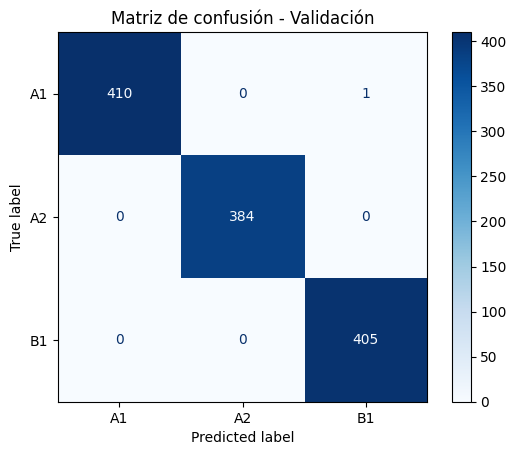

Matriz de confusión del conjunto de prueba:
[[420   0   3]
 [  0 383   0]
 [  1   0 393]]


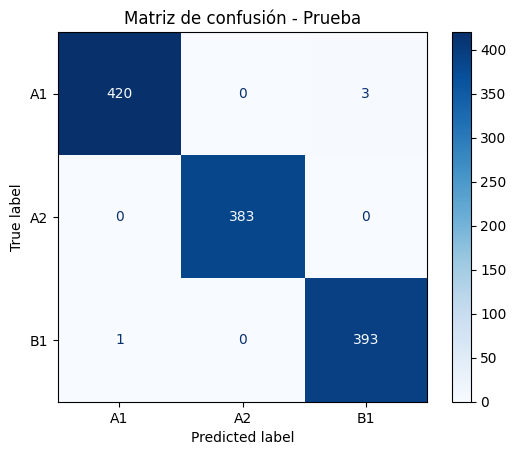

In [4]:

from sklearn.metrics import ConfusionMatrixDisplay


conf_matrix_val = confusion_matrix(y_val, val_pred)
print("Matriz de confusión del conjunto de validación:")
print(conf_matrix_val)

# Visualizar la matriz de confusión para el conjunto de validación
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_val, display_labels=grid_search.classes_)
disp.plot(cmap='Blues')
plt.title('Matriz de confusión - Validación')
plt.show()

# Matriz de confusión para el conjunto de prueba
conf_matrix_test = confusion_matrix(y_test, test_pred)
print("Matriz de confusión del conjunto de prueba:")
print(conf_matrix_test)

# Visualizar la matriz de confusión para el conjunto de prueba
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=best_classifier.classes_)
disp.plot(cmap='Blues')
plt.title('Matriz de confusión - Prueba')
plt.show()

# K-Nearest Neighbors


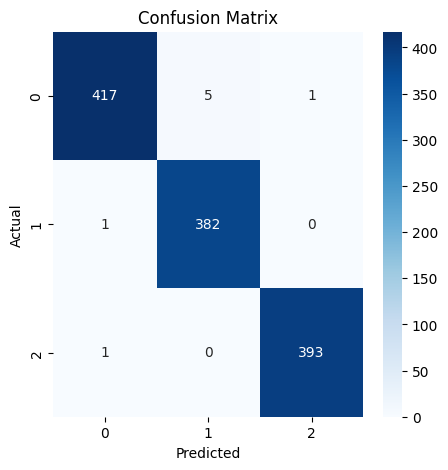

ACCURACY SCORE: 0.9933
CLASSIFICATION REPORT:
	Precision: 0.9934
	Recall: 0.9933
	F1 Score: 0.9933


In [5]:
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
tfidf = TfidfVectorizer(ngram_range=(1, 1))

# Crear pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', knn)])

# Ajustar el modelo en el conjunto de entrenamiento
pipe.fit(train_data['sentence'], train_data['difficulty'])

# Predecir los valores en el conjunto de prueba
y_pred_knn = pipe.predict(test_data['sentence'])

# Evaluar las métricas de KNN
precision_knn, recall_knn, f1_knn, accuracy_knn = models_metrics(test_data['difficulty'], y_pred_knn)


# Decision Tree

The optimal depth - 15 trees with CV score: 97.97195 ± 0.5592


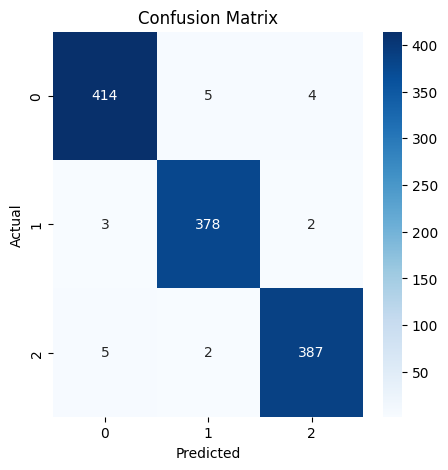

ACCURACY SCORE: 0.9825
CLASSIFICATION REPORT:
	Precision: 0.9825
	Recall: 0.9825
	F1 Score: 0.9825


(np.float64(0.982501782595683),
 np.float64(0.9825),
 np.float64(0.9824977555135035),
 0.9825)

In [6]:
# Preparar los datos para el modelo
tfidf = TfidfVectorizer(ngram_range=(1, 1))
X_train_vec = tfidf.fit_transform(train_data['sentence'])
y_train = train_data['difficulty']
X_test_vec = tfidf.transform(test_data['sentence'])
y_test = test_data['difficulty']

# Definir la profundidad máxima de los árboles
tree_depths = range(1, 26)
cv_scores_mean, cv_scores_std, accuracy_scores = run_cross_validation_on_trees(X_train_vec, y_train, tree_depths)

# Encontrar el mejor modelo
max_score = cv_scores_mean.argmax()
best_tree_depth = tree_depths[max_score]
best_tree_cv_score = cv_scores_mean[max_score]
best_tree_cv_score_std = cv_scores_std[max_score]

print(f'The optimal depth - {best_tree_depth} trees with CV score: {round(best_tree_cv_score*100, 5)} ± {round(best_tree_cv_score_std*100, 5)}')

# Entrenar el modelo final
Tree = DecisionTreeClassifier(max_depth=best_tree_depth, random_state=42)
Tree.fit(X_train_vec, y_train)

# Predecir los valores en el conjunto de prueba
tree_pred = Tree.predict(X_test_vec)

# Evaluar las métricas de Árbol de Decisión
models_metrics(y_test, tree_pred)

# Random Forest

Random Forest Metrics:


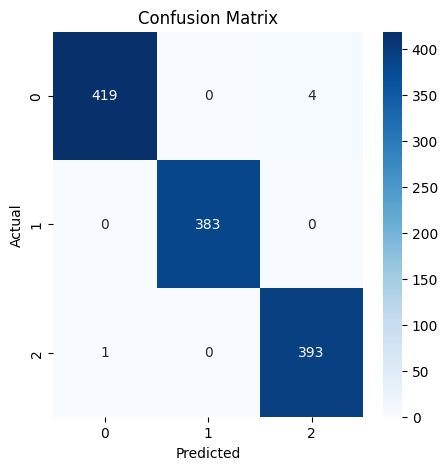

ACCURACY SCORE: 0.9958
CLASSIFICATION REPORT:
	Precision: 0.9959
	Recall: 0.9958
	F1 Score: 0.9958


(np.float64(0.9958525698692574),
 np.float64(0.9958333333333333),
 np.float64(0.9958338207263504),
 0.9958333333333333)

In [7]:
# Entrenar el modelo de Random Forest
from sklearn.ensemble import RandomForestClassifier


classifier_rf = RandomForestClassifier(n_estimators=400, criterion="entropy", random_state=42)
classifier_rf.fit(X_train_vec, y_train)

# Predecir los valores en el conjunto de prueba para el Random Forest
y_pred_rf = classifier_rf.predict(X_test_vec)

# Evaluar las métricas de Random Forest
print("Random Forest Metrics:")
models_metrics(y_test, y_pred_rf)